# Lets try to predict CRA of alzheimer disease

![](http://yourcooladviser.in/wp-content/uploads/2017/06/stages-of-alzheimers-disease-21.jpg)

In [9]:
%matplotlib inline
import tensorflow as tf
import glob
import seaborn as sns
import pandas as pd
import numpy as np
import timeit
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.utils import np_utils
from tensorflow.python.keras import utils

In [12]:
cross1=pd.read_csv('./../../data/mri-and-alzheimers/oasis_longitudinal.csv') 
cross1 = cross1.fillna(method='ffill')
cross2=pd.read_csv('./../../data/mri-and-alzheimers/oasis_cross-sectional.csv')
cross2 = cross2.fillna(method='ffill')

In [13]:
cross1.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,2.0,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,2.0,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,2.0,22.0,0.5,1698,0.701,1.034


In [14]:
cross2.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,4.0,3.0,27.0,0.5,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,4.0,3.0,27.0,0.5,1737,0.848,1.010,NaN


In [15]:
cross1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
Subject ID    373 non-null object
MRI ID        373 non-null object
Group         373 non-null object
Visit         373 non-null int64
MR Delay      373 non-null int64
M/F           373 non-null object
Hand          373 non-null object
Age           373 non-null int64
EDUC          373 non-null int64
SES           373 non-null float64
MMSE          373 non-null float64
CDR           373 non-null float64
eTIV          373 non-null int64
nWBV          373 non-null float64
ASF           373 non-null float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


In [16]:
cross2.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,4.0,3.0,27.0,0.5,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,4.0,3.0,27.0,0.5,1737,0.848,1.010,NaN


In [17]:
cross2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
ID       436 non-null object
M/F      436 non-null object
Hand     436 non-null object
Age      436 non-null int64
Educ     436 non-null float64
SES      436 non-null float64
MMSE     436 non-null float64
CDR      436 non-null float64
eTIV     436 non-null int64
nWBV     436 non-null float64
ASF      436 non-null float64
Delay    20 non-null float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB


Populating the interactive namespace from numpy and matplotlib


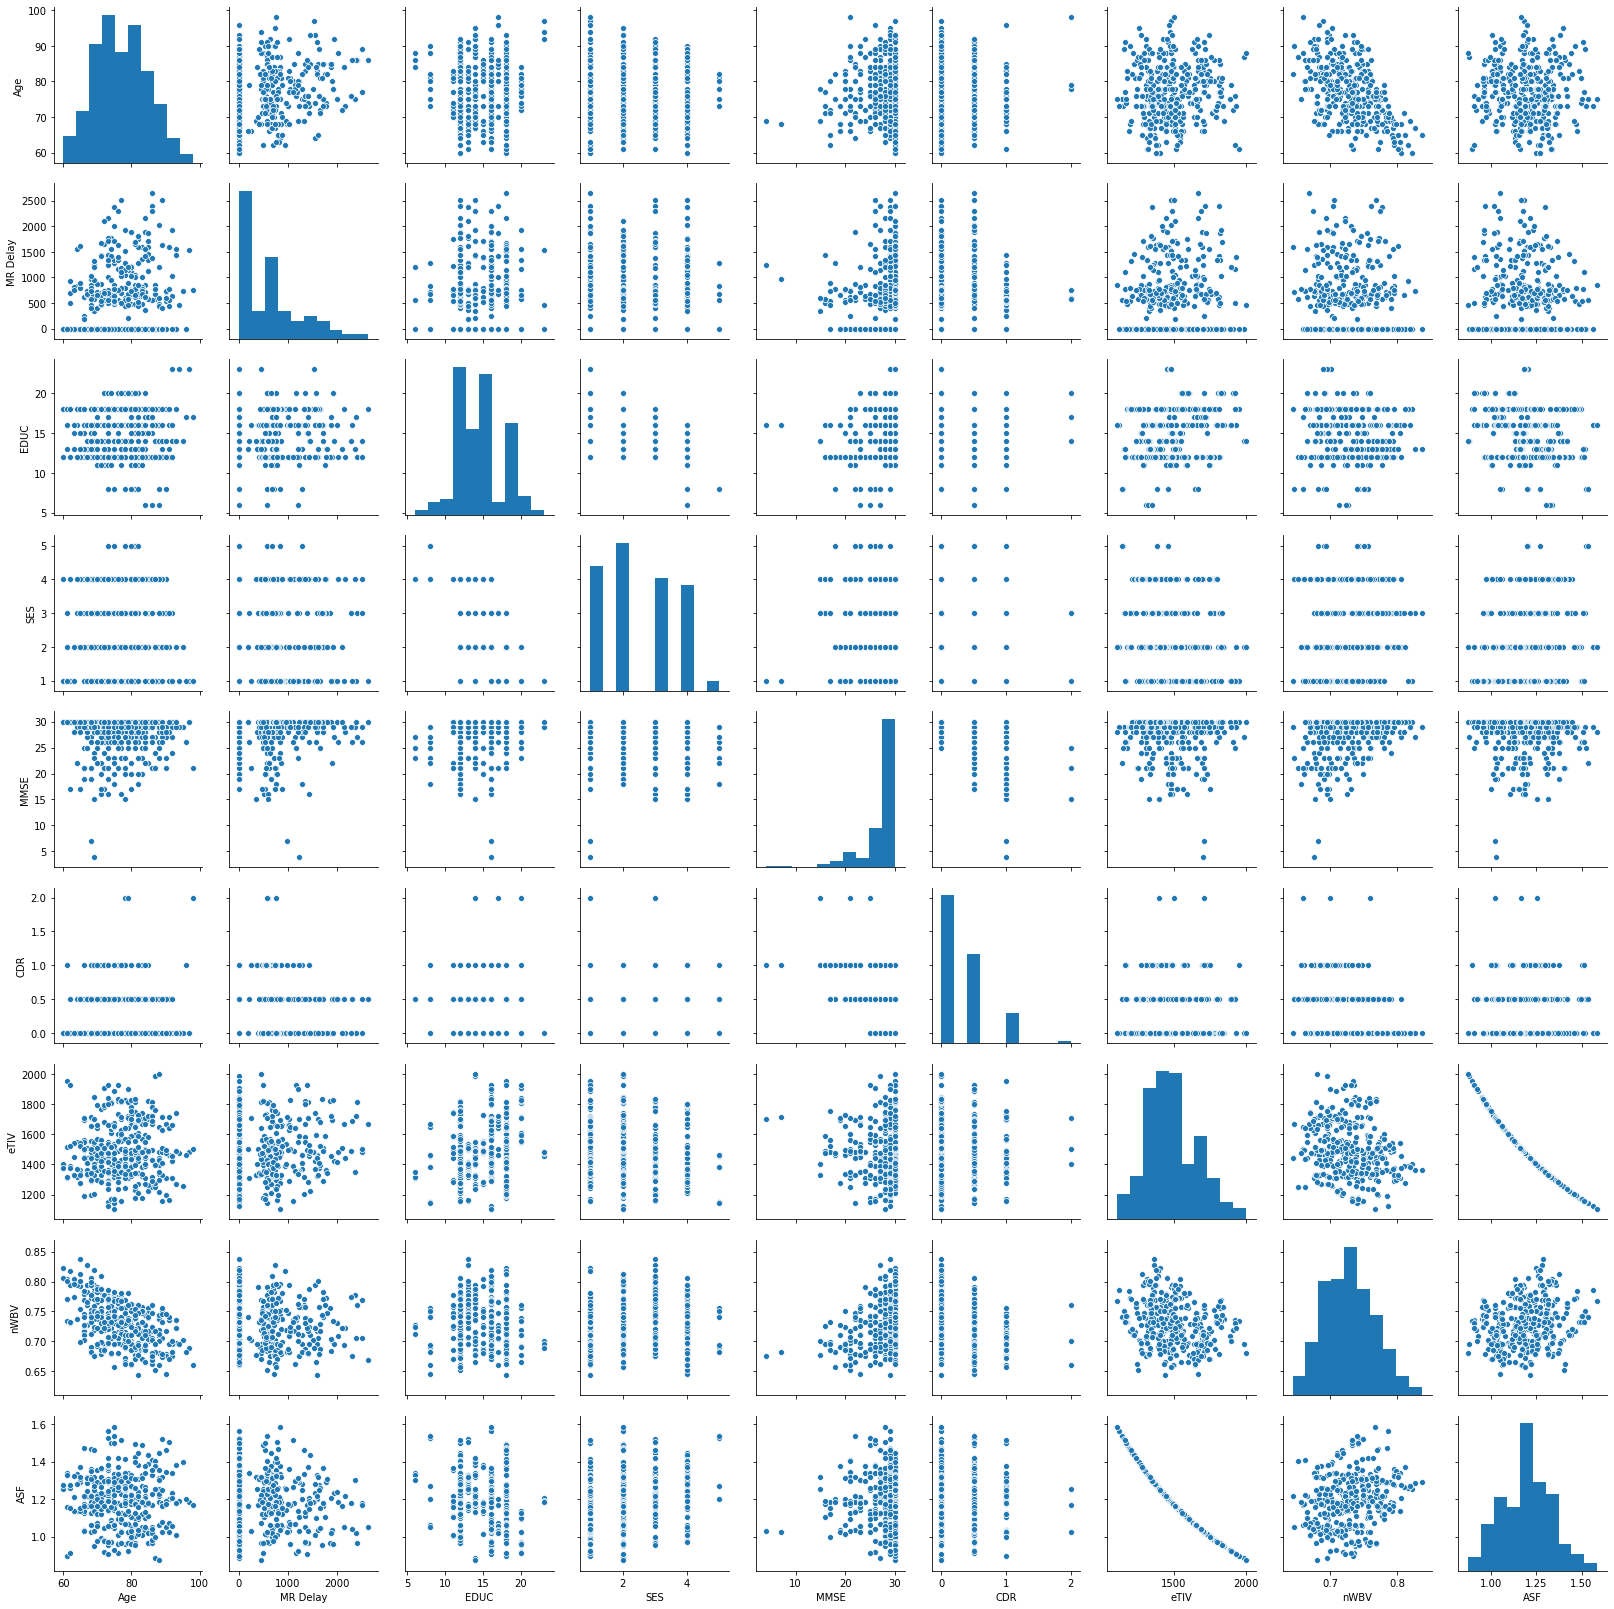

In [18]:
%pylab inline
#lets plot some graphics from the first dataset

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
cols = ['Age','MR Delay', 'EDUC', 'SES', 'MMSE', 'CDR','eTIV','nWBV','ASF']
x=cross1.fillna('')
sns_plot = sns.pairplot(x[cols])

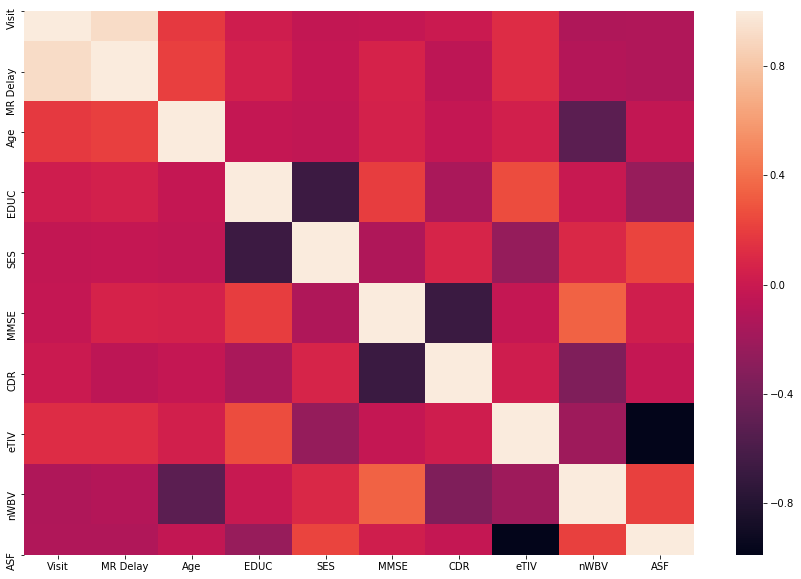

In [19]:
#lets plot correleation matrix
corr_matrix =cross1.corr()
rcParams['figure.figsize'] = 15, 10
sns.heatmap(corr_matrix)

In [20]:
cross1.drop(['MRI ID'], axis=1, inplace=True)
cross1.drop(['Visit'], axis=1, inplace=True)

In [21]:
#cdr=cross1["CDR"]
cross1['CDR'].replace(to_replace=0.0, value='A', inplace=True)
cross1['CDR'].replace(to_replace=0.5, value='B', inplace=True)
cross1['CDR'].replace(to_replace=1.0, value='C', inplace=True)
cross1['CDR'].replace(to_replace=2.0, value='D', inplace=True)

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
for x in cross1.columns:
    f = LabelEncoder()
    cross1[x] = f.fit_transform(cross1[x])

In [24]:
cross1.head()

,Subject ID,Group,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,2,0,1,0,27,5,1,14,0,284,35,1
1,0,2,15,1,0,28,5,1,17,0,285,20,0
2,1,1,0,1,0,15,3,1,10,1,231,73,52
3,1,1,32,1,0,16,3,1,15,1,254,51,32
4,1,1,185,1,0,20,3,1,9,1,238,40,46


In [25]:
#cdr.replace(to_replace=0.0, value='A', inplace=True)
#cdr.replace(to_replace=0.5, value='B', inplace=True)
#cdr.replace(to_replace=1.0, value='C', inplace=True)
#cdr.replace(to_replace=2.0, value='D', inplace=True)

In [26]:
#from sklearn.preprocessing import LabelBinarizer
#encoder=LabelBinarizer()
#z1=encoder.fit_transform(cdr)

In [27]:
#print(z1)

# Lets begin some machine learning

In [28]:
train, test = train_test_split(cross1, test_size=0.3)

In [29]:
X_train = train[['M/F', 'Age', 'EDUC', 'SES',  'eTIV', 'ASF']]
y_train = train.CDR
X_test = test[['M/F', 'Age', 'EDUC', 'SES',  'eTIV',  'ASF']]
y_test = test.CDR

In [30]:
# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

In [31]:
y_train=np.ravel(y_train)
X_train=np.asarray(X_train)

y_test=np.ravel(y_test)
X_test=np.asarray(X_test)


In [32]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

/home/maziyar/anaconda3/envs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/maziyar/anaconda3/envs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [33]:
classifier.score(X_test, y_test)

0.5982142857142857

In [34]:
classifier.score(X_train, y_train)

0.6091954022988506

In [35]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(max_depth=12)
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)
print (classifier.score(X_train, y_train))
print (classifier.score(X_test, y_test))

0.9961685823754789
0.6160714285714286


In [36]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
print(knn.score(X_train, y_train))
prediction = knn.predict(X_test)
print(knn.score(X_test, y_test))


0.8467432950191571
0.6607142857142857


In [37]:
from sklearn.svm import SVC
svc=SVC(kernel="linear", C=0.01)
svc.fit(X_train, y_train)
prediction = svc.predict(X_test)

In [38]:
svc.score(X_test, y_test)

0.5625

In [39]:
svc.score(X_train, y_train)

0.5478927203065134

In [40]:
X_train.shape

(261, 6)

## Neural net tensorflow

![](http://it-nowosti.ru/wp-content/uploads/2015/11/google-otkryvaet-isxodnyj-kod-si.jpg)

In [45]:
import tensorflow as tf
from sklearn import metrics
X_FEATURE = 'x'  # Name of the input feature.
feature_columns = [
      tf.feature_column.numeric_column(
          X_FEATURE, shape=np.array(X_train).shape[1:])]

classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns, hidden_units=[35,70, 35], n_classes=4, loss_reduction=tf.keras.losses.Reduction.SUM)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp4gn20_kl', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3442cee710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [47]:
  # Predict.
test_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(x={X_FEATURE: X_test}, y=y_test, num_epochs=1, shuffle=False)
predictions = classifier.predict(input_fn=test_input_fn)
y_predicted = np.array(list(p['class_ids'] for p in predictions))
y_predicted = y_predicted.reshape(np.array(y_test).shape)

  # Score with sklearn.
score = metrics.accuracy_score(y_test, y_predicted)
print('Accuracy (sklearn): {0:f}'.format(score))

  # Score with tensorflow.
scores = classifier.evaluate(input_fn=test_input_fn)
print('Accuracy (tensorflow): {0:f}'.format(scores['accuracy']))


#if __name__ == '__main__':
   # tf.app.run()

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp4gn20_kl/model.ckpt-204
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy (sklearn): 0.625000
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to 

In [48]:
y_train

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 3, 1, 1, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 1, 0, 1, 2, 0, 2, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2,
       0, 0, 1, 1, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0, 0, 1, 2,
       0, 0, 0, 0, 1, 1, 2, 0, 0, 1, 0, 1, 1, 0, 2, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 2, 3, 0, 0, 0, 0, 2, 2, 1, 2, 0, 2, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 3, 1,
       0, 0, 1, 1, 1, 1, 0, 2, 0, 2, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 2, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 1, 1, 0])

# We need to concat both datasets because we have insufficient data

In [49]:
cross1.head()

,Subject ID,Group,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,2,0,1,0,27,5,1,14,0,284,35,1
1,0,2,15,1,0,28,5,1,17,0,285,20,0
2,1,1,0,1,0,15,3,1,10,1,231,73,52
3,1,1,32,1,0,16,3,1,15,1,254,51,32
4,1,1,185,1,0,20,3,1,9,1,238,40,46


In [50]:
cross2.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,4.0,3.0,27.0,0.5,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,4.0,3.0,27.0,0.5,1737,0.848,1.010,NaN


In [51]:
#lets encode second dataset
for x in cross2.columns:
    f = LabelEncoder()
    cross2[x] = f.fit_transform(cross2[x])

In [52]:
#concanting both datasets
df = pd.concat([cross1,cross2])

/home/maziyar/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [53]:
df = df.fillna(method='ffill')
df.head()


,ASF,Age,CDR,Delay,EDUC,Educ,Group,Hand,ID,M/F,MMSE,MR Delay,SES,Subject ID,eTIV,nWBV
0,1,27,0,NaN,5.0,NaN,2.0,0,NaN,1,14,0.0,1,0.0,284,35
1,0,28,0,NaN,5.0,NaN,2.0,0,NaN,1,17,15.0,1,0.0,285,20
2,52,15,1,NaN,3.0,NaN,1.0,0,NaN,1,10,0.0,1,1.0,231,73
3,32,16,1,NaN,3.0,NaN,1.0,0,NaN,1,15,32.0,1,1.0,254,51
4,46,20,1,NaN,3.0,NaN,1.0,0,NaN,1,9,185.0,1,1.0,238,40


In [54]:
train, test = train_test_split(cross1, test_size=0.3)
X_train1 = train[['ASF', 'Age', 'EDUC', 'Group',  'Hand', 'M/F','MMSE','MR Delay','SES','eTIV','nWBV']]
y_train1 = train.CDR
X_test1 = test[['ASF', 'Age', 'EDUC', 'Group',  'Hand', 'M/F','MMSE','MR Delay','SES','eTIV','nWBV']]
y_test1 = test.CDR

In [55]:
# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train1)

# Scale the train set
X_train1 = scaler.transform(X_train1)

# Scale the test set
X_test1 = scaler.transform(X_test1)

In [56]:
y_train1=np.ravel(y_train1)
X_train1=np.asarray(X_train1)

y_test1=np.ravel(y_test1)
X_test1=np.asarray(X_test1)

In [57]:
X_train1

array([[-1.42767018,  0.4072807 , -1.09077791, ...,  0.53721733,
         1.42978779,  0.72363525],
       [-0.1319574 , -0.63360314, -1.48237768, ...,  1.44182198,
         0.16358728, -1.14107788],
       [ 1.56779485,  1.31805405, -1.09077791, ...,  1.44182198,
        -1.57110741, -1.82184616],
       ...,
       [-0.99576592,  0.53739118,  1.25882073, ..., -0.36738733,
         0.99927962, -1.40746547],
       [ 1.88823995, -0.2432717 ,  0.47562118, ..., -0.36738733,
        -1.86233352,  1.07881871],
       [-0.41060531, -1.54437649, -1.09077791, ...,  1.44182198,
         0.4548134 , -0.7562958 ]])

In [58]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train1, y_train1)
prediction = classifier.predict(X_test1)
print(classifier.score(X_train1, y_train1))
print(classifier.score(X_test1, y_test1))

0.8045977011494253
0.8214285714285714


/home/maziyar/anaconda3/envs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/maziyar/anaconda3/envs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [59]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(X_train1, y_train1)
prediction = classifier.predict(X_test1)
print (classifier.score(X_train1, y_train1))
print (classifier.score(X_test1, y_test1))

0.9272030651340997
0.8660714285714286


In [60]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train1, y_train1)
print(knn.score(X_train1, y_train1))
prediction = knn.predict(X_test1)
print(knn.score(X_test1, y_test1))

0.8888888888888888
0.8660714285714286


In [62]:
import tensorflow as tf
from sklearn import metrics
X_FEATURE = 'x'  # Name of the input feature.
feature_columns = [
      tf.feature_column.numeric_column(
          X_FEATURE, shape=np.array(X_train).shape[1:])]

classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns, hidden_units=[35,70, 35], n_classes=4, loss_reduction=tf.keras.losses.Reduction.SUM)

  # Train.
train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(x={X_FEATURE: X_train}, y=y_train, num_epochs=100, shuffle=False)
classifier.train(input_fn=train_input_fn, steps=1000)

  # Predict.
test_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(x={X_FEATURE: X_test}, y=y_test, num_epochs=1, shuffle=False)
predictions = classifier.predict(input_fn=test_input_fn)
y_predicted = np.array(list(p['class_ids'] for p in predictions))
y_predicted = y_predicted.reshape(np.array(y_test).shape)

  # Score with sklearn.
score = metrics.accuracy_score(y_test, y_predicted)
print('Accuracy (sklearn): {0:f}'.format(score))

  # Score with tensorflow.
scores = classifier.evaluate(input_fn=test_input_fn)
print('Accuracy (tensorflow): {0:f}'.format(scores['accuracy']))


#if __name__ == '__main__':
   # tf.app.run()


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpnt3nmnds', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f337868b860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely 

In [63]:
import tensorflow as tf
from sklearn import metrics
X_FEATURE = 'x'  # Name of the input feature.
feature_columns = [
      tf.feature_column.numeric_column(
          X_FEATURE, shape=np.array(X_train).shape[1:])]

classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns, hidden_units=[35,70, 35], n_classes=4, loss_reduction=tf.keras.losses.Reduction.SUM)

  # Train.
train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(x={X_FEATURE: X_train}, y=y_train, num_epochs=100, shuffle=False)
classifier.train(input_fn=train_input_fn, steps=1000)

  # Predict.
test_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(x={X_FEATURE: X_test}, y=y_test, num_epochs=1, shuffle=False)
predictions = classifier.predict(input_fn=test_input_fn)
y_predicted = np.array(list(p['class_ids'] for p in predictions))
y_predicted = y_predicted.reshape(np.array(y_test).shape)

  # Score with sklearn.
score = metrics.accuracy_score(y_test, y_predicted)
print('Accuracy (sklearn): {0:f}'.format(score))

  # Score with tensorflow.
scores = classifier.evaluate(input_fn=test_input_fn)
print('Accuracy (tensorflow): {0:f}'.format(scores['accuracy']))


#if __name__ == '__main__':
   # tf.app.run()


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpkzqzk75j', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f344008b710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely 

### And the winner is  DecisionTreeClassifier! 

### Conclusion: we need more data for more precise analysis